## Problem Statement

Perform customer segmentation for an Online Retail using an Unsupervised Clustering technique (K-Means)

### Import Required packages

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Data Wrangling

In [ ]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Online_Retail.zip
!unzip -qq Online_Retail.zip

## Load the data

In [ ]:
# YOUR CODE HERE
df = pd.read_csv("/content/Online_Retail_Train.csv")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2,2011-11-29 13:04:00,8.50,16479.0,United Kingdom
1,554092,21916,SET 12 RETRO WHITE CHALK STICKS,24,2011-05-22 12:41:00,0.42,17176.0,United Kingdom
2,577774,84692,BOX OF 24 COCKTAIL PARASOLS,6,2011-11-21 15:57:00,0.42,16712.0,United Kingdom
3,C571196,23350,ROLL WRAP VINTAGE SPOT,-12,2011-10-14 12:02:00,1.25,NaN,United Kingdom
4,546649,84509a,SET OF 4 ENGLISH ROSE PLACEMATS,1,2011-03-15 14:17:00,7.46,NaN,United Kingdom


## Data Pre-processing (2 points)

Explore the dataset by performing the following operations:

* There is a lot of redundant data. Identify such data and take appropriate action.

  **Hint:** refer to this [link](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html)

* Most Invoices appear as normal transactions with positive quantity and prices, but there are some prefixed with "C" or "A" which denote different transaction types. Invoice starting with C represents cancelled order and A represents the Adjusted. Identify such data and take appropriate action.

  **Hint:** Check the negative values in Quantity column for all cancelled orders

* Handle the null values by dropping or filling with appropriate mean


* Some of the transactions based on the `StockCode` variable are not actually products, but representing the costs or fees regarding to the post or bank or other tansactions. Find such data and handle it accordingly.

  Hint:
    - The transaction with `'POST' 'PADS' 'M' 'DOT' 'C2' 'BANK CHARGES'` as their `StockCodes` are considered as irrelevant transactions.

* Identify the outliers in the UntiPrice and Quantity and handle them accordingly.

  **Hint:** [link](https://kanoki.org/2020/04/23/how-to-remove-outliers-in-python/)

* Create a DayOfWeek column using `InvoiceDate`, Hint: pd.to_datetime()

**Note:** Perform all the above operations using a function to reuse and apply the same for test data.

In [ ]:
print('Dimesiong before', df.shape)
df.drop_duplicates(inplace=True)
print('Dimesiong after', df.shape)

Dimesiong before (514813, 8)
Dimesiong after (510059, 8)


In [ ]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1385
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     128222
Country             0
dtype: int64

In [ ]:
#Make the indexing correct
df.reset_index(inplace=True)
df.drop(labels=['index'],axis=1,inplace=True)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2,2011-11-29 13:04:00,8.50,16479.0,United Kingdom
1,554092,21916,SET 12 RETRO WHITE CHALK STICKS,24,2011-05-22 12:41:00,0.42,17176.0,United Kingdom
2,577774,84692,BOX OF 24 COCKTAIL PARASOLS,6,2011-11-21 15:57:00,0.42,16712.0,United Kingdom
3,C571196,23350,ROLL WRAP VINTAGE SPOT,-12,2011-10-14 12:02:00,1.25,NaN,United Kingdom
4,546649,84509a,SET OF 4 ENGLISH ROSE PLACEMATS,1,2011-03-15 14:17:00,7.46,NaN,United Kingdom


In [ ]:
# 0. for unregistered 1 for registered
df['Customer_status'] = df.CustomerID.apply(lambda x: 0 if np.isnan(x) else 1)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Customer_status
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2,2011-11-29 13:04:00,8.50,16479.0,United Kingdom,1
1,554092,21916,SET 12 RETRO WHITE CHALK STICKS,24,2011-05-22 12:41:00,0.42,17176.0,United Kingdom,1
2,577774,84692,BOX OF 24 COCKTAIL PARASOLS,6,2011-11-21 15:57:00,0.42,16712.0,United Kingdom,1
3,C571196,23350,ROLL WRAP VINTAGE SPOT,-12,2011-10-14 12:02:00,1.25,NaN,United Kingdom,0
4,546649,84509a,SET OF 4 ENGLISH ROSE PLACEMATS,1,2011-03-15 14:17:00,7.46,NaN,United Kingdom,0


In [ ]:
# filling missing customerID values, same invoice number will have same customer ID
max_id = df['CustomerID'].max()
unique_invoices = df.loc[df.CustomerID.isna(), 'InvoiceNo'].unique()

for x in unique_invoices:
  df.loc[df.InvoiceNo == x, 'CustomerID'] = str(max_id)
  max_id += 1

df.isna().sum()

InvoiceNo             0
StockCode             0
Description        1385
Quantity              0
InvoiceDate           0
UnitPrice             0
CustomerID            0
Country               0
Customer_status       0
dtype: int64

In [ ]:
df.dropna(axis=0,inplace=True) #to drop Description null values
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Customer_status
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2,2011-11-29 13:04:00,8.50,16479,United Kingdom,1
1,554092,21916,SET 12 RETRO WHITE CHALK STICKS,24,2011-05-22 12:41:00,0.42,17176,United Kingdom,1
2,577774,84692,BOX OF 24 COCKTAIL PARASOLS,6,2011-11-21 15:57:00,0.42,16712,United Kingdom,1
3,C571196,23350,ROLL WRAP VINTAGE SPOT,-12,2011-10-14 12:02:00,1.25,18287.0,United Kingdom,0
4,546649,84509a,SET OF 4 ENGLISH ROSE PLACEMATS,1,2011-03-15 14:17:00,7.46,18288.0,United Kingdom,0


In [ ]:
#To drop transactions where status = Cancelled
index = df.InvoiceNo[df.InvoiceNo.str.contains('C') == True].index
df.drop(index = index, inplace = True)
df.shape

(499911, 9)

In [ ]:
# 0 for cancelled, -1 for adjusted and 1 for a normal order
df["transaction_status"] = df["InvoiceNo"].apply(lambda x: 0 if 'A' in x else 1)

#for removing redundant values in stock code
redundant = ['POST','PADS','M', 'DOT','C2','BANK CHARGES']
df_filtered = df[~df['StockCode'].isin(redundant)]
print(df.shape)
df_filtered.head()

(499911, 10)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Customer_status,transaction_status
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2,2011-11-29 13:04:00,8.50,16479,United Kingdom,1,1
1,554092,21916,SET 12 RETRO WHITE CHALK STICKS,24,2011-05-22 12:41:00,0.42,17176,United Kingdom,1,1
2,577774,84692,BOX OF 24 COCKTAIL PARASOLS,6,2011-11-21 15:57:00,0.42,16712,United Kingdom,1,1
4,546649,84509a,SET OF 4 ENGLISH ROSE PLACEMATS,1,2011-03-15 14:17:00,7.46,18288.0,United Kingdom,0,1
5,579668,23575,SNACK TRAY PAISLEY PARK,8,2011-11-30 12:32:00,1.95,15152,United Kingdom,1,1


In [ ]:
#UnitPrice and Quantity outliers
from scipy import stats
df_filtered['z_score_UnitPrice'] = stats.zscore(df_filtered['UnitPrice'])
df_filtered['z_score_Quantity'] = stats.zscore(df_filtered['Quantity'])

print(len(df_filtered.loc[df_filtered['z_score_UnitPrice'].abs() > 3 ]))
print(len(df_filtered.loc[df_filtered['z_score_Quantity'].abs() > 3 ]))

#They are less in count so we can go ahead and drop them.
df_filtered = df_filtered.loc[(df_filtered['z_score_UnitPrice'].abs() <= 3)  & (df_filtered['z_score_Quantity'].abs() <= 3)]
df_filtered.drop(labels=['z_score_UnitPrice', 'z_score_Quantity'],axis=1,inplace=True)
df_filtered.shape

119
468


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


(497130, 10)

In [ ]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497130 entries, 0 to 510058
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   InvoiceNo           497130 non-null  object 
 1   StockCode           497130 non-null  object 
 2   Description         497130 non-null  object 
 3   Quantity            497130 non-null  int64  
 4   InvoiceDate         497130 non-null  object 
 5   UnitPrice           497130 non-null  float64
 6   CustomerID          497130 non-null  object 
 7   Country             497130 non-null  object 
 8   Customer_status     497130 non-null  int64  
 9   transaction_status  497130 non-null  int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 41.7+ MB


In [ ]:
df_filtered["DayOfWeek"] = pd.to_datetime(df['InvoiceDate']).dt.day_name()
df_filtered.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Customer_status,transaction_status,DayOfWeek
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2,2011-11-29 13:04:00,8.50,16479,United Kingdom,1,1,Tuesday
1,554092,21916,SET 12 RETRO WHITE CHALK STICKS,24,2011-05-22 12:41:00,0.42,17176,United Kingdom,1,1,Sunday
2,577774,84692,BOX OF 24 COCKTAIL PARASOLS,6,2011-11-21 15:57:00,0.42,16712,United Kingdom,1,1,Monday
4,546649,84509a,SET OF 4 ENGLISH ROSE PLACEMATS,1,2011-03-15 14:17:00,7.46,18288.0,United Kingdom,0,1,Tuesday
5,579668,23575,SNACK TRAY PAISLEY PARK,8,2011-11-30 12:32:00,1.95,15152,United Kingdom,1,1,Wednesday


In [ ]:
#Creating a function

def drop_duplicates(dataf):
  dataf.drop_duplicates(inplace=True)
  dataf.reset_index(inplace=True)
  dataf.drop(labels=['index'],axis=1,inplace=True)
  return dataf


def handleNans(dataF):
  #creating a column for registered and non-registered customers
  dataF['Customer_status'] = dataF.CustomerID.apply(lambda x: 0 if np.isnan(x) else 1)
  #handling customerID nan values with summy IDs
  max_id = dataF['CustomerID'].max()
  unique_invoices = dataF.loc[dataF.CustomerID.isna(), 'InvoiceNo'].unique()
  for x in unique_invoices:
    dataF.loc[dataF.InvoiceNo == x, 'CustomerID'] = str(max_id)
    max_id += 1
  #removing other nan values
  dataF.dropna(axis=0,inplace=True)
  return dataF


def extraProcessing(df):
  #remove transactions with cancelled status
  index = df.InvoiceNo[df.InvoiceNo.str.contains('C') == True].index
  df.drop(index = index, inplace = True)
  #column for transaction status
  df["transaction_Status"] = df["InvoiceNo"].apply(lambda x: 0 if 'A' in x else 1)
  #for removing redundant values in stock code
  redundant = ['POST','PADS','M', 'DOT','C2','BANK CHARGES']
  df = df[~df['StockCode'].isin(redundant)]
  #removing outliers
  df['z_score_UnitPrice'] = stats.zscore(df['UnitPrice'])
  df['z_score_Quantity'] = stats.zscore(df['Quantity'])
  df = df.loc[(df['z_score_UnitPrice'].abs() <= 3)  & (df['z_score_Quantity'].abs() <= 3)]
  df.drop(labels=['z_score_UnitPrice', 'z_score_Quantity'],axis=1,inplace=True)
  #creating a column for day of the week
  df_filtered["DayOfWeek"] = pd.to_datetime(df['InvoiceDate']).dt.day_name()
  return df


## Understanding new insights from the data (1 point)

1.  Are there any free items in the data? How many are there?

2.  Find the number of transactions per country and visualize using an appropriate plot

3.  What is the ratio of customers who are repeat purchasers vs single-time purchasers? Visualize using an appropriate plot.

4. Plot heatmap showing unit price per month and day of the week

  **Hint:** Month name as index on Y-axis, Day of the week on X-axis

5. Find the top 10 customers who bought the most no.of items. Also find the top 10 Items bought by most no.of customers.

In [ ]:
#Total number of Free items in Data
df_zero = df_filtered[(df_filtered['UnitPrice']==0) & (df_filtered['Quantity'] > 0) ]
df_zero['Description'].nunique()

225

In [ ]:
df_filtered.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Customer_status,transaction_status,DayOfWeek
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2,2011-11-29 13:04:00,8.50,16479,United Kingdom,1,1,Tuesday
1,554092,21916,SET 12 RETRO WHITE CHALK STICKS,24,2011-05-22 12:41:00,0.42,17176,United Kingdom,1,1,Sunday
2,577774,84692,BOX OF 24 COCKTAIL PARASOLS,6,2011-11-21 15:57:00,0.42,16712,United Kingdom,1,1,Monday
4,546649,84509a,SET OF 4 ENGLISH ROSE PLACEMATS,1,2011-03-15 14:17:00,7.46,18288.0,United Kingdom,0,1,Tuesday
5,579668,23575,SNACK TRAY PAISLEY PARK,8,2011-11-30 12:32:00,1.95,15152,United Kingdom,1,1,Wednesday


In [ ]:
df_filtered['Country'].value_counts()

United Kingdom          455754
Germany                   8178
France                    7667
EIRE                      7358
Spain                     2294
Netherlands               2183
Belgium                   1848
Switzerland               1840
Portugal                  1376
Australia                 1121
Norway                    1003
Channel Islands            706
Italy                      702
Finland                    618
Cyprus                     566
Unspecified                421
Sweden                     397
Austria                    366
Denmark                    351
Poland                     311
Japan                      292
Israel                     278
Hong Kong                  264
Singapore                  202
Iceland                    171
USA                        166
Canada                     140
Greece                     133
Malta                      103
United Arab Emirates        62
RSA                         54
European Community          53
Lebanon 

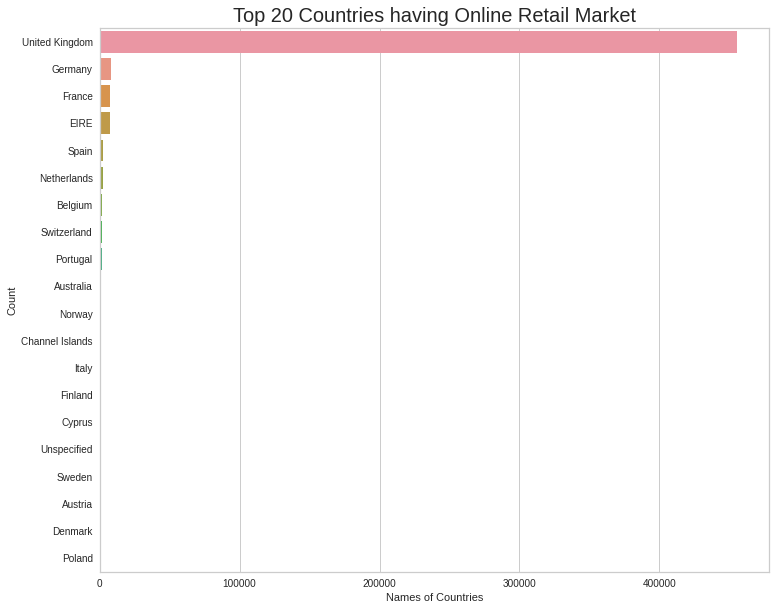

In [ ]:
# checking the different values for country in the dataset
plt.rcParams['figure.figsize'] = (12, 10)
a = df_filtered['Country'].value_counts().head(20)
sns.barplot(x = a.values, y = a.index)
plt.title('Top 20 Countries having Online Retail Market', fontsize = 20)
plt.xlabel('Names of Countries')
plt.ylabel('Count')
plt.show()

In [ ]:
df_filtered.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Customer_status,transaction_status,DayOfWeek,total_amount
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2,2011-11-29 13:04:00,8.50,16479,United Kingdom,1,1,Tuesday,17.00
1,554092,21916,SET 12 RETRO WHITE CHALK STICKS,24,2011-05-22 12:41:00,0.42,17176,United Kingdom,1,1,Sunday,10.08
2,577774,84692,BOX OF 24 COCKTAIL PARASOLS,6,2011-11-21 15:57:00,0.42,16712,United Kingdom,1,1,Monday,2.52
4,546649,84509a,SET OF 4 ENGLISH ROSE PLACEMATS,1,2011-03-15 14:17:00,7.46,18288.0,United Kingdom,0,1,Tuesday,7.46
5,579668,23575,SNACK TRAY PAISLEY PARK,8,2011-11-30 12:32:00,1.95,15152,United Kingdom,1,1,Wednesday,15.60


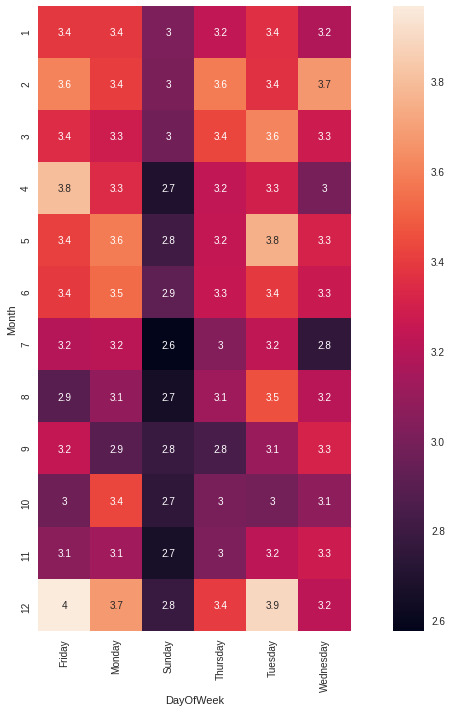

In [ ]:
# Plot heatmap showing unit price per month and day of the week
df_filtered['Month'] = pd.to_datetime(df['InvoiceDate']).dt.month

piv = pd.pivot_table(df_filtered, values="UnitPrice",index=["Month"], columns=["DayOfWeek"], fill_value=0,aggfunc='mean')
#plot pivot table as heatmap using seaborn
ax = sns.heatmap(piv, square=True, annot = True)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=90 )
plt.tight_layout()
plt.show()

**December Friday and Tuesday has the highest average unit price. July Sundays have the least avg unit price.**

In [ ]:
#Find the top 10 customers who bought the most no.of items. Also find the top 10 Items bought by most no.of customers.
print(df_filtered.groupby(by = 'Description').count().InvoiceNo.nlargest(10))

Description
WHITE HANGING HEART T-LIGHT HOLDER    2188
JUMBO BAG RED RETROSPOT               2001
REGENCY CAKESTAND 3 TIER              1921
PARTY BUNTING                         1626
LUNCH BAG RED RETROSPOT               1521
ASSORTED COLOUR BIRD ORNAMENT         1389
SET OF 3 CAKE TINS PANTRY DESIGN      1331
PACK OF 72 RETROSPOT CAKE CASES       1281
LUNCH BAG  BLACK SKULL.               1241
NATURAL SLATE HEART CHALKBOARD        1185
Name: InvoiceNo, dtype: int64


In [ ]:
print(df_filtered.groupby(by = 'CustomerID').count().InvoiceNo.nlargest(10))

CustomerID
17841.0    7310
14911.0    5280
14096.0    4841
12748.0    4165
14606.0    2554
15311.0    2249
14646.0    1936
13089.0    1736
13263.0    1599
14298.0    1543
Name: InvoiceNo, dtype: int64


## Feature Engineering and Transformation (2 points)

### Create new features to uncover better insights and drop the unwanted columns

* Create a new column which represents Total amount spent by each customer

    **Hint:** Quantity * UnitPrice

* Customer IDs are seen to be repeated. Maintain unique customer IDs by grouping and summing up all possible observations per customer.

    **Hint:** [pandas.groupby.agg](https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.core.groupby.DataFrameGroupBy.agg.html)

**Note:** Perform the above operations in function, to reuse and apply the same for test data

In [ ]:
import datetime as dt
df_filtered.InvoiceDate = pd.to_datetime(df_filtered.InvoiceDate)
snapshot_date = max(df_filtered.InvoiceDate) + dt.timedelta(days=1)
print('Last date of transaction: {}'.format(snapshot_date.date()))

Last date of transaction: 2011-12-10


In [ ]:
# how much they spend (revenue), how often they spend (frequency), are they new or existing customers, what are their favorite products, etc

df_filtered['total_amount'] = df_filtered['Quantity']*df_filtered['UnitPrice']

df_final = df_filtered.groupby(['Customer_status', 'CustomerID',],as_index=False).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'total_amount': 'sum',
    'InvoiceNo': 'count'
}).rename(columns = {'InvoiceDate': 'Recency', 'total_amount': 'MonetaryValue','InvoiceNo': 'Frequency'})
df_final.head()

,Customer_status,CustomerID,Recency,MonetaryValue,Frequency
0,0,18288.0,269,343.67,42
1,0,18289.0,102,1371.59,206
2,0,18290.0,9,5582.90,654
3,0,18291.0,17,3298.95,466
4,0,18292.0,367,5015.82,565


In [ ]:
total_Customers = df_final.shape[0]
single_time = len(df_final[df_final['Frequency']==1])
ratio = (total_Customers - single_time)/single_time
print("Ratio of customers who are repeat purchasers vs single-time purchasers: ",ratio)

ratio of customers who are repeat purchasers vs single-time purchasers:  6.795994993742178


([<matplotlib.patches.Wedge at 0x7fb9d66fccd0>,
 [Text(-0.4313726307584153, -1.0118881625123224, 'Repeat'),
  Text(0.4705883244637259, 1.1038779954679878, 'Single')],
 [Text(-0.23529416223186286, -0.5519389977339939, '87.2%'),
  Text(0.2745098559371734, 0.6439288306896596, '12.8%')])

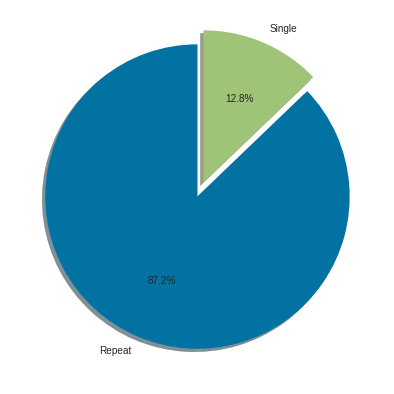

In [ ]:
plt.figure(figsize=(7,7))
plt.pie([total_Customers - single_time, single_time], explode=(0,0.1), labels = ['Repeat', 'Single'],autopct='%1.1f%%', shadow=True, startangle=90)

In [ ]:
X = df_final[['MonetaryValue', 'Frequency','Recency','Customer_status']]
print(X.shape)
X.head()

(6229, 4)


,MonetaryValue,Frequency,Recency,Customer_status
0,343.67,42,269,0
1,1371.59,206,102,0
2,5582.90,654,9,0
3,3298.95,466,17,0
4,5015.82,565,367,0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

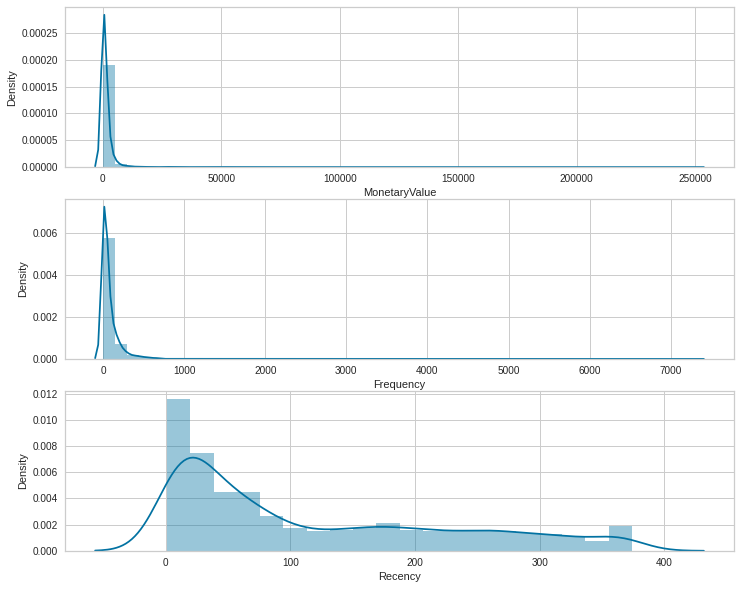

In [ ]:
plt.figure(figsize=(12,10))
plt.subplot(3, 1, 1); sns.distplot(X['MonetaryValue'])
plt.subplot(3, 1, 2); sns.distplot(X['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(X['Recency'])

**The distribution of Recency is very skewed which, in this case, is actually good. We see that the majority of clients have bought something between 0 and 50 days ago.**

**From the above figure, all the variables do not have a symmetrical distribution. All of them are skewed to the right. To remove the skewness.**

In [ ]:
#to determine outliers in data for all the columns
def viewDistribution(rfm):
    sns.boxplot(data = rfm)
    plt.xticks(rotation=90)
    plt.show

# UDF to remove outlier
def remove_outlier_IQR(rfm):
    Q1 = rfm.quantile(0.25)
    Q3 = rfm.quantile(0.75)
    IQR = Q3-Q1
    rfm1 = rfm[~((rfm < (Q1-1.5*IQR)) | (rfm >(Q3+1.5*IQR)))]
    return rfm1

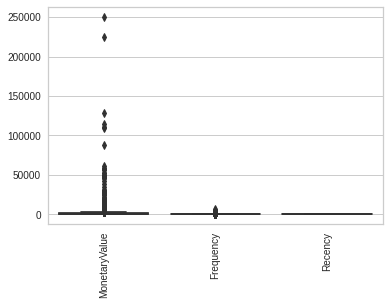

In [ ]:
X_anomaly = X.iloc[:,0:3]
viewDistribution(X_anomaly)

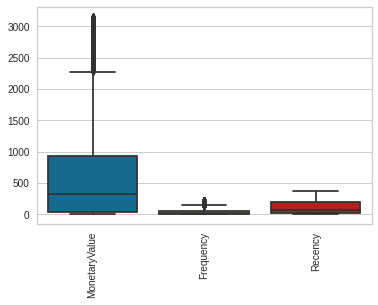

In [ ]:
X_IQR = remove_outlier_IQR(X)
X_IQR.fillna(0,inplace=True)
viewDistribution(X_IQR.iloc[:,0:3])

In [ ]:
X_IQR.head()

,MonetaryValue,Frequency,Recency,Customer_status
0,343.67,42.0,269,0
1,1371.59,206.0,102,0
2,0.00,0.0,9,0
3,0.00,0.0,17,0
4,0.00,0.0,367,0


### Scale the data
 
Apply `StandardScaler` on the features.

In [ ]:
# YOUR CODE HERE for scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_IQR)

In [ ]:
X_df = pd.DataFrame(X_scaled, columns=["MonetaryValue", "Frequency", "Recency","Customer_status"])
X1 = X_df[['MonetaryValue', 'Frequency','Recency']]
X2 = X_df[['MonetaryValue', 'Frequency','Customer_status']]

## Clustering ( 5 points)

### Apply k-means algorithm to identify a specific number of clusters


* Fit the k-means model

* Extract and store the cluster centroids

Below are the parameters for k-means, which are helpful

**n_clusters** is no. of clusters specified

**k-means++** is a random initialization method for centroids to avoid random initialisation trap

**max_iter** is max no of iterations defined when k-means is running

**n_init** is no. of times k-means will run with different initial centroids

[why-is-k-means-slower-than-random-initialization-k-means](https://stats.stackexchange.com/questions/185396/why-is-k-means-slower-than-random-initialization-k-means/185422)

#### Find the optimal number of clusters (K) by using the [Elbow method](https://pythonprogramminglanguage.com/kmeans-elbow-method/).

Use the optimal no. of clusters and store the cluster centroids

In [ ]:
# YOUR CODE HERE to apply KMeans

def calcScores(X):
  distortion = []
  sil_score = []
  for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X)
    distortion.append(km.inertia_)
    sil_score.append(silhouette_score(X, km.labels_))
  return distortion, sil_score

distortion1, silScore1 = calcScores(X1)
distortion2, silScore2 = calcScores(X2)

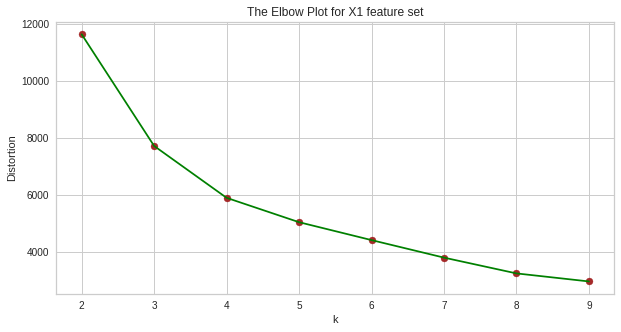

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(2,10), distortion1, color = "green")
plt.scatter(np.arange(2,10), distortion1, color = "brown")
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Plot for X1 feature set')
plt.show()

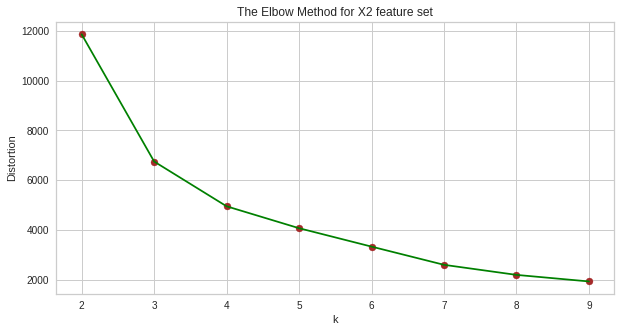

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(2,10), distortion2, color = "green")
plt.scatter(np.arange(2,10), distortion2, color = "brown")
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method for X2 feature set')
plt.show()

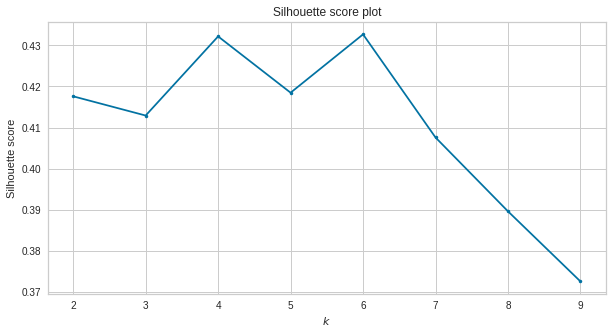

In [ ]:
# Plot Silhouette score plot
plt.figure(figsize=(10,5))
plt.plot(np.arange(2,10), silScore1, marker= '.')
plt.title('Silhouette score plot')
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.show()

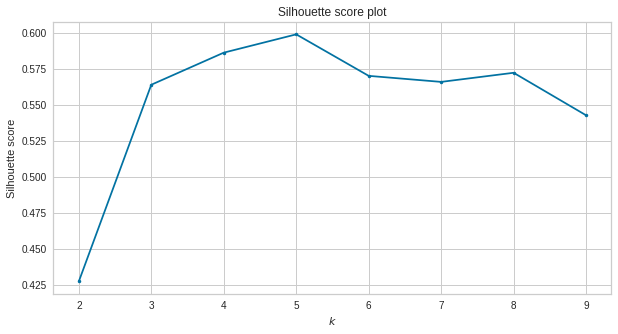

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(2,10), silScore2, marker= '.')
plt.title('Silhouette score plot')
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.show()

In [ ]:
kmeans1 = KMeans(n_jobs = -1, n_clusters = 4, init='k-means++',random_state=1)
kmeans1.fit(X1)
pred1 = kmeans1.predict(X1)
X1['ClusterID'] = pred1
X1['ClusterID'].value_counts()

0    2753
2    1817
1    1033
3     626
Name: ClusterID, dtype: int64

In [ ]:
kmeans2 = KMeans(n_jobs = -1, n_clusters = 5, init='k-means++',random_state=1)
kmeans2.fit(X2)
pred2 = kmeans2.predict(X2)
X2['ClusterID'] = pred2
X2['ClusterID'].value_counts()

2    3007
0    1569
4     896
1     471
3     286
Name: ClusterID, dtype: int64

In [ ]:
print(kmeans1.cluster_centers_)
print(kmeans2.cluster_centers_)

[[-0.4206388  -0.41466211 -0.60184165]
 [ 1.78814967  0.57585277 -0.54215551]
 [-0.4731675  -0.45386572  1.29111864]
 [ 0.26530788  2.18741766 -0.20028646]]
[[-0.62976576 -0.61144282 -1.50091356]
 [-0.08646281  1.9053554   0.66626089]
 [-0.31158732 -0.36837037  0.66626089]
 [ 0.99307758  2.0614415  -1.50091356]
 [ 1.87695238  0.64737591  0.5211376 ]]


### Apply DBSCAN algorithm for clustering

- Compare the results of clusters from k-means and DBSCAN


In [ ]:
DB_X1 = X1.drop('ClusterID',axis=1)
DB_X2 = X2.drop('ClusterID',axis=1)

In [ ]:
# YOUR CODE HERE
db1 = DBSCAN(eps=0.8, min_samples= 7, metric='euclidean')
db2 = DBSCAN(eps=0.8, min_samples= 7, metric='euclidean')

db1.fit(DB_X1)
db2.fit(DB_X2)
print("Unique clusters in data group 1: ", np.unique(db1.labels_))
print("Unique clusters in data group 2: ", np.unique(db2.labels_))


Unique clusters in data group 1:  [-1  0]
Unique clusters in data group 2:  [0 1]


In [ ]:
cluster_labels1 = db1.labels_
cluster_labels2 = db2.labels_
print("The silhouette score is", format(silhouette_score(DB_X1, cluster_labels1)))
print("The silhouette score is", format(silhouette_score(DB_X2, cluster_labels2)))

The silhouette score is 0.44727537912025633
The silhouette score is 0.4880550091577898


In [ ]:
DB_X1['Label'] = db1.labels_
DB_X2['Label'] = db2.labels_

DB_X1.head()

,MonetaryValue,Frequency,Recency,Label
0,-0.372412,-0.005062,1.384864,0
1,1.051463,3.232646,-0.128085,0
2,-0.848464,-0.834231,-0.970625,0
3,-0.848464,-0.834231,-0.898149,0
4,-0.848464,-0.834231,2.272702,0


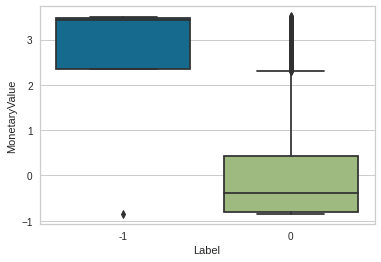

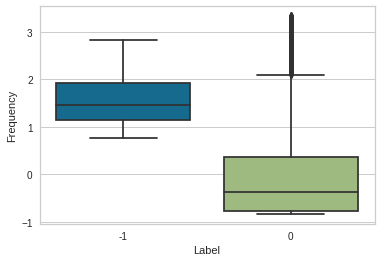

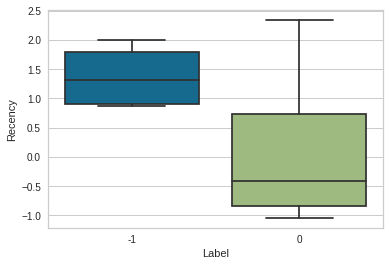

In [ ]:
for c in DB_X1.columns[:-1]:
    plt.figure(figsize=(6,4))
    sns.boxplot(data = DB_X1, y=c, x='Label')
    plt.show()

### Analyze the clusters


- consider two features and visualize the clusters with different colors using the predicted cluster centers.

  **Hint:** 2D plot

- consider three features and visualize the clusters with different colors using the predicted cluster centers.

  **Hint:** [3D plot](https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html
)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


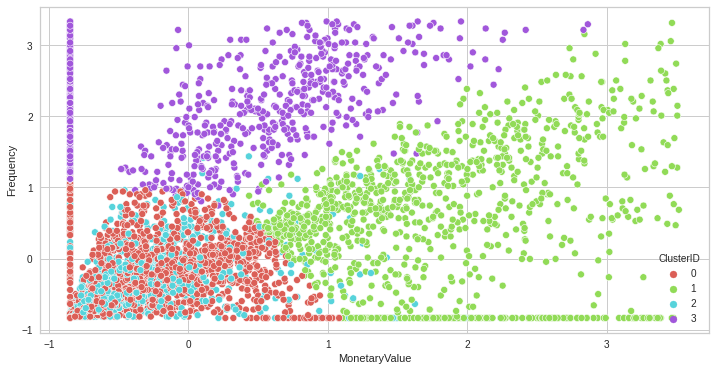

In [ ]:
# YOUR CODE HERE
plt.figure(figsize=(12,6))
sns.scatterplot(X1['MonetaryValue'] ,X1['Frequency'], hue = X1['ClusterID'], palette = sns.color_palette('hls',4))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


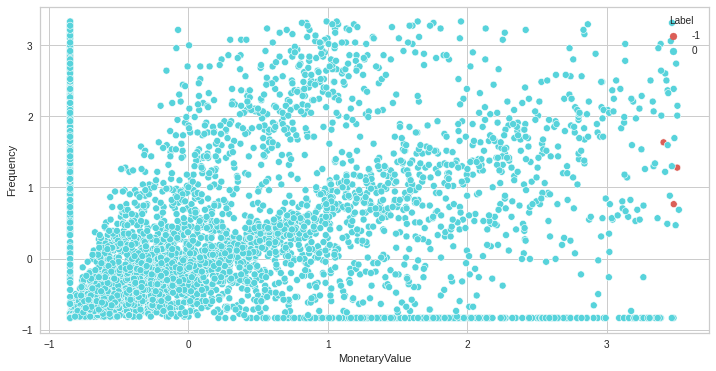

In [ ]:
plt.figure(figsize=(12,6))
sns.scatterplot(DB_X1['MonetaryValue'] ,DB_X1['Frequency'], hue = DB_X1['Label'], palette = sns.color_palette('hls',2))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


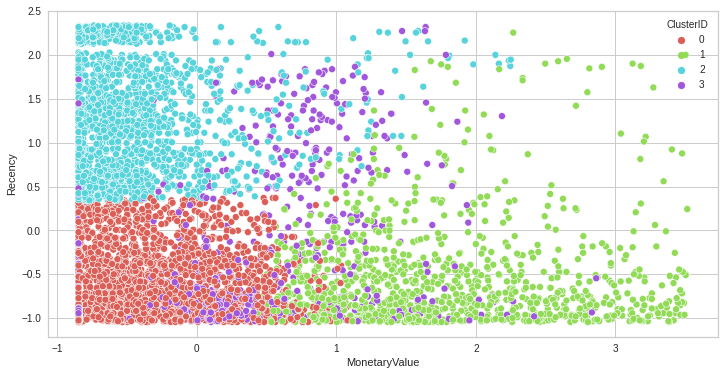

In [ ]:
plt.figure(figsize=(12,6))
sns.scatterplot(X1['MonetaryValue'] ,X1['Recency'], hue = X1['ClusterID'] , palette = sns.color_palette('hls',4))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


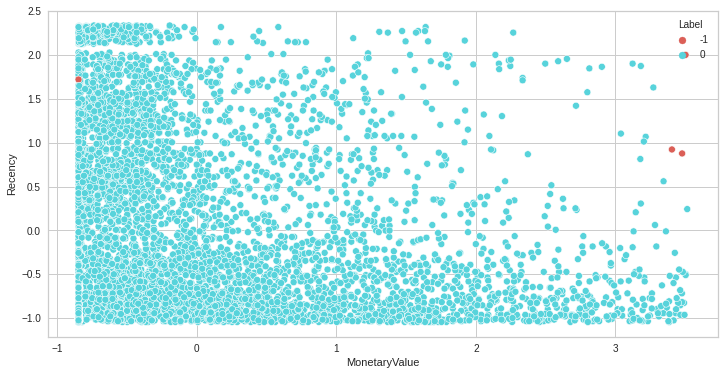

In [ ]:
plt.figure(figsize=(12,6))
sns.scatterplot(DB_X1['MonetaryValue'] ,DB_X1['Recency'], hue = DB_X1['Label'] , palette = sns.color_palette('hls',2))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


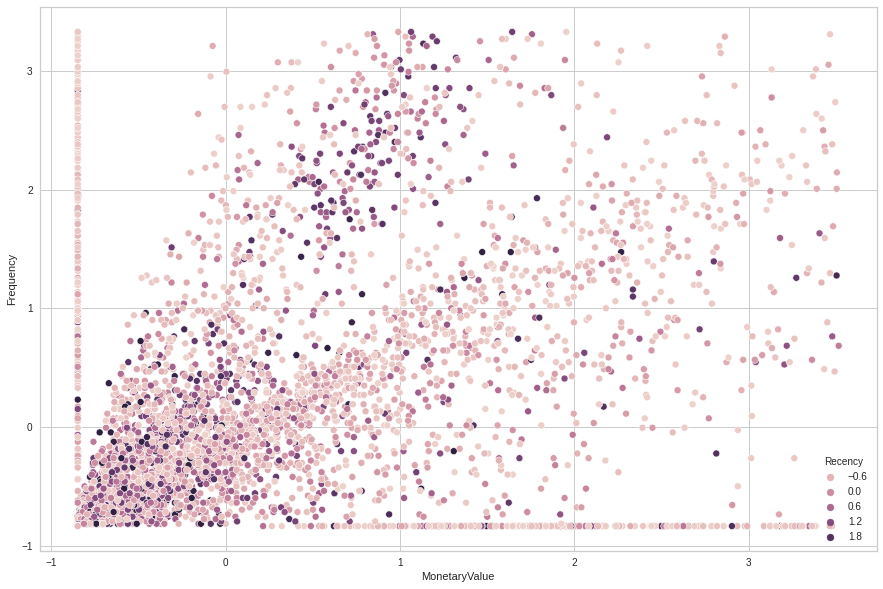

In [ ]:
plt.figure(figsize=(15,10))
sns.scatterplot(X1['MonetaryValue'], X1['Frequency'], X1['Recency'], hue = X1['ClusterID'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


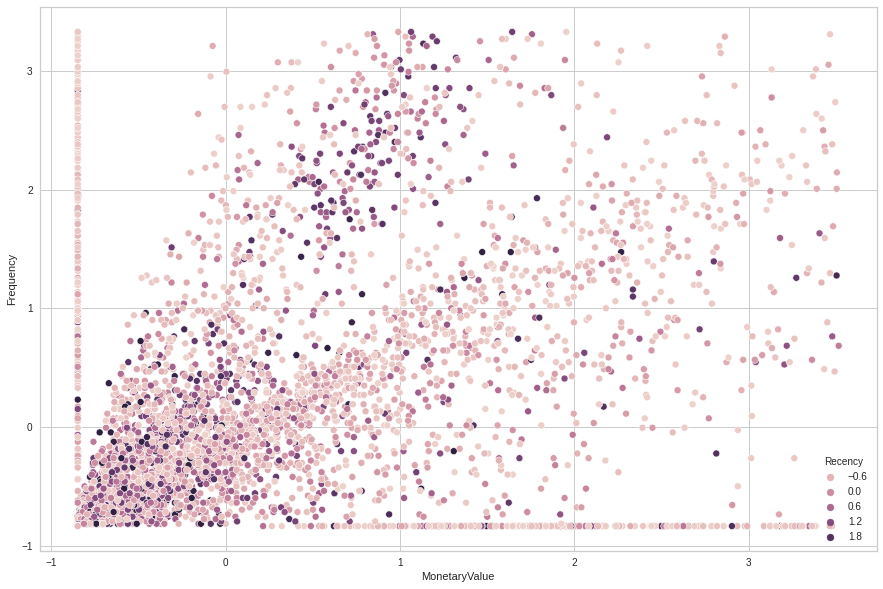

In [ ]:
plt.figure(figsize=(15,10))
sns.scatterplot(DB_X1['MonetaryValue'], DB_X1['Frequency'], DB_X1['Recency'], hue = DB_X1['Label'])

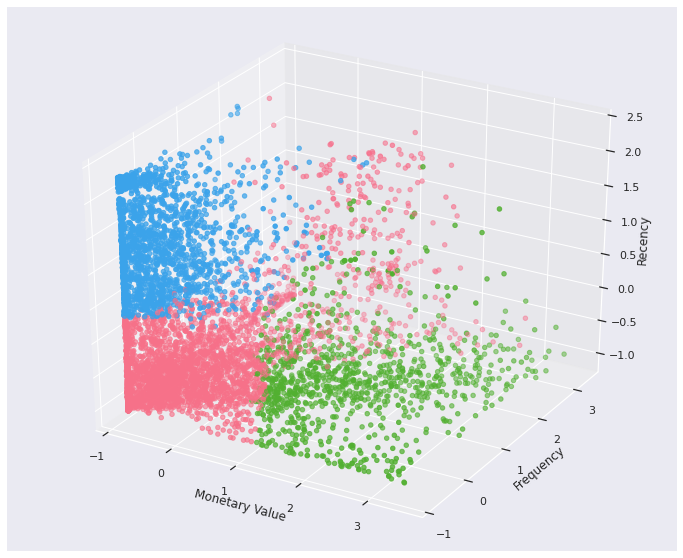

In [ ]:
from matplotlib.colors import ListedColormap
sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = X1['MonetaryValue'] 
y = X1['Frequency'] 
z = X1['Recency']

ax.set_xlabel("Monetary Value")
ax.set_ylabel("Frequency")
ax.set_zlabel("Recency")
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

ax.scatter(x, y, z, c=X1['ClusterID'],cmap=cmap)

plt.show()

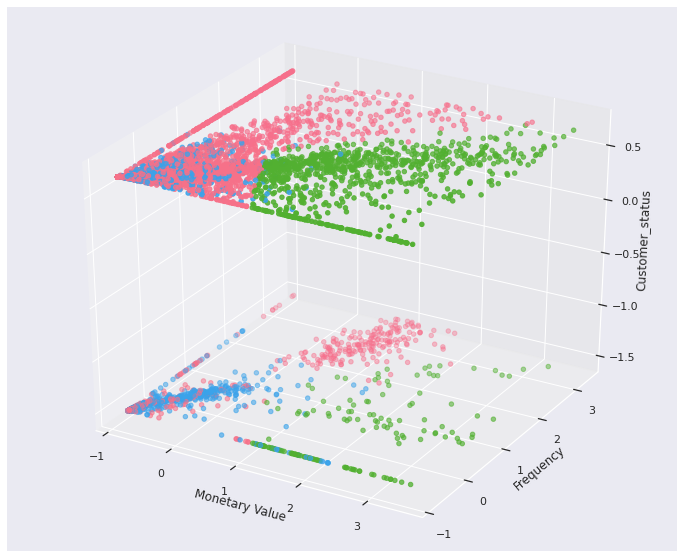

In [ ]:
sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = X2['MonetaryValue'] 
y = X2['Frequency'] 
z = X2['Customer_status']

ax.set_xlabel("Monetary Value")
ax.set_ylabel("Frequency")
ax.set_zlabel("Customer_status")
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

ax.scatter(x, y, z, c=X1['ClusterID'],cmap=cmap)

plt.show()

In [ ]:
X_IQR['ClusterID'] = X1['ClusterID']

In [ ]:
summary = X_IQR.groupby(['ClusterID']).agg({'Recency': 'mean',
                                                    'Frequency': 'mean',
                                                    'MonetaryValue': ['mean', 'count'],}).round(0)
summary

Recency Frequency MonetaryValue      
             mean      mean          mean count
ClusterID                                      
0            50.0      21.0         310.0  2753
1            56.0      71.0        1905.0  1033
2           259.0      19.0         271.0  1817
3            94.0     153.0         804.0   626

[Text(0, 0.5, 'Recency')]

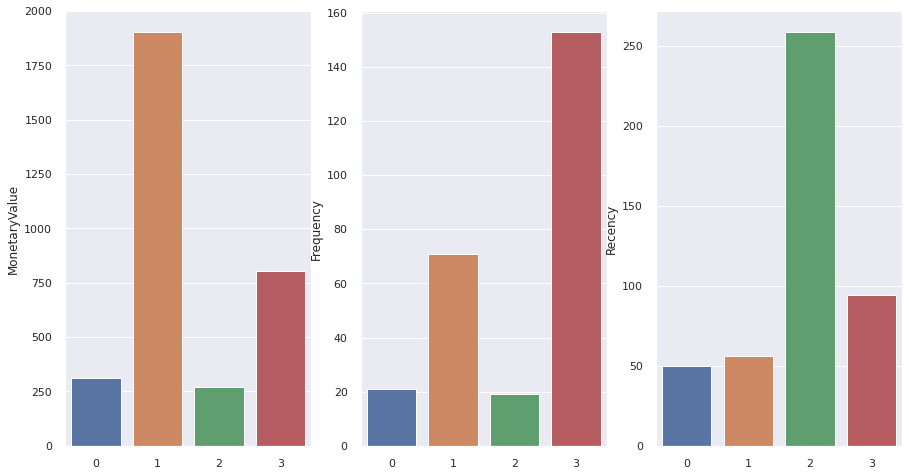

In [ ]:
fig, axs = plt.subplots(1,3, figsize = (15, 8))
axs[0] = sns.barplot(x = [0,1,2,3],  y = summary[:]['MonetaryValue']['mean'] , ax = axs[0],)
axs[1] = sns.barplot(x = [0,1,2,3],  y = summary[:]['Frequency']['mean'] , ax = axs[1])
axs[2] = sns.barplot(x = [0,1,2,3],  y = summary[:]['Recency']['mean'] , ax = axs[2])

axs[0].set( ylabel='MonetaryValue')
axs[1].set( ylabel='Frequency')
axs[2].set( ylabel='Recency')


<b>Cluster 0 : Not spending much money, recency is lower than the other clusters and Freqency is also low, can say that they are new customers.

Cluster 1 & 3 : They are the loyal customers, as there frequency and investing amount is more though their recency is less.

Cluster 2: Frequency and spending amount is less though their recency is high, can put them in the lost customers category.

In [ ]:
X_IQR['R_rank'] = X_IQR['Recency'].rank( ascending=False)
X_IQR['F_rank'] = X_IQR['Frequency'].rank(ascending=True)
X_IQR['M_rank'] = X_IQR['MonetaryValue'].rank(ascending=True)
X_IQR.head()
# normalize each rank with Max rank
X_IQR['R_rank_norm']=(X_IQR['R_rank']/X_IQR['R_rank'].max())*100
X_IQR['F_rank_norm']=(X_IQR['F_rank']/X_IQR['F_rank'].max())*100
X_IQR['M_rank_norm']=(X_IQR['F_rank']/X_IQR['M_rank'].max())*100
X_IQR.head()
# Now apply our equation and create final score **Consolidated Score = 0.15*R_rank_norm + 0.28*F_rank_norm + 0.57M_rank_norm**
X_IQR['RFM_Score']=0.15*X_IQR['R_rank_norm']+0.28*X_IQR['F_rank_norm']+0.57*X_IQR['M_rank_norm']
X_IQR=X_IQR.round(0)
X_IQR.head()

,MonetaryValue,Frequency,Recency,Customer_status,ClusterID,R_rank,F_rank,M_rank,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score
0,344.0,42.0,269,0,2,842.0,4063.0,3182.0,14.0,65.0,65.0,57.0
1,1372.0,206.0,102,0,3,2568.0,6198.0,5270.0,42.0,100.0,99.0,91.0
2,0.0,0.0,9,0,0,5540.0,272.0,560.0,90.0,4.0,4.0,17.0
3,0.0,0.0,17,0,0,5056.0,272.0,560.0,82.0,4.0,4.0,16.0
4,0.0,0.0,367,0,2,98.0,272.0,560.0,2.0,4.0,4.0,4.0


In [ ]:
# ## Customer segments with RFM Model
# # Segment customers based on RFM score
# 0 - 50 - Low valued customer
# 50 - 75 - Medium valued customer
# 76 - 100 - High valued customer
X_IQR["Customer_segment"]=np.where(X_IQR['RFM_Score'] > 75 ,"High Value Customer",(np.where(X_IQR['RFM_Score'] < 50 , "Low value Customer" ,"Medium Value Customer")))
X_IQR.head()

,MonetaryValue,Frequency,Recency,Customer_status,ClusterID,R_rank,F_rank,M_rank,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Customer_segment
0,344.0,42.0,269,0,2,842.0,4063.0,3182.0,14.0,65.0,65.0,57.0,Medium Value Customer
1,1372.0,206.0,102,0,3,2568.0,6198.0,5270.0,42.0,100.0,99.0,91.0,High Value Customer
2,0.0,0.0,9,0,0,5540.0,272.0,560.0,90.0,4.0,4.0,17.0,Low value Customer
3,0.0,0.0,17,0,0,5056.0,272.0,560.0,82.0,4.0,4.0,16.0,Low value Customer
4,0.0,0.0,367,0,2,98.0,272.0,560.0,2.0,4.0,4.0,4.0,Low value Customer


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


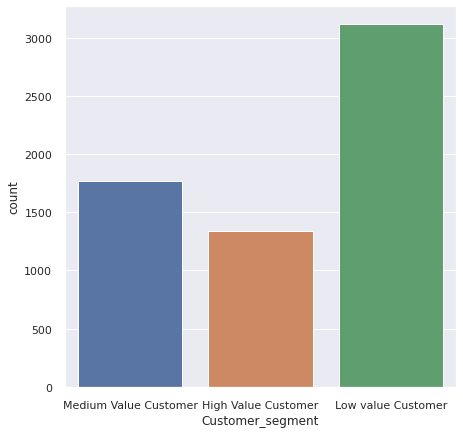

In [ ]:
plt.figure(figsize=(7,7))
sns.countplot(X_IQR['Customer_segment'])

### Train a supervised algorithm on clustered data

This will allow us to predict cluster numbers (label) for each test data instance

* Create labelled data with k-means cluster labels
  
  **Hint**: [`kmeans.labels_`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
)
* Split the data into train and validation sets
* Train a supervised algorithm on the train data
* Find the accuracy of the model using validation data

In [ ]:
# YOUR CODE HERE
X = X1.drop('ClusterID',axis=1)
y = X1['ClusterID']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

log_clf = LogisticRegression(random_state=42, solver="saga", penalty="l2", class_weight="balanced", C=0.8, max_iter=500)
log_clf.fit(X_train, y_train)
y_pred = log_clf.predict(X_test)
print(log_clf.__class__.__name__, log_clf.score(X_train, y_train))
print(log_clf.__class__.__name__, log_clf.score(X_test, y_test))
print(log_clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.9829420028095525
LogisticRegression 0.9775280898876404
LogisticRegression 0.9775280898876404


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import tree
dec_clf = tree.DecisionTreeClassifier(random_state=10)
#hyperparamters to tune
parameters = dict(max_depth=[10,12,14,18,20], criterion=['gini', 'entropy'])
gs_clf = GridSearchCV(dec_clf, parameters)
gs_clf.fit(X_train, y_train)
print('Best Criterion:', gs_clf.best_estimator_.get_params()['criterion'])
print('Best max_depth:', gs_clf.best_estimator_.get_params()['max_depth'])

Best Criterion: gini
Best max_depth: 12


In [ ]:
dt_clf = tree.DecisionTreeClassifier(max_depth = 12, criterion = 'gini', random_state = 10)
dt_clf.fit(X_train, y_train)
y_pred = dt_clf.predict(X_test)
print(dt_clf.__class__.__name__, accuracy_score(y_test, y_pred))

DecisionTreeClassifier 0.9911717495987159


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators = 550,random_state= 123, 
                                max_depth = 15, criterion = 'entropy', n_jobs = -1)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print(rf_clf.__class__.__name__, accuracy_score(y_test, y_pred))

RandomForestClassifier 0.9935794542536116


### Evaluation of Test Data
* Use the model to predict the labels for the Test data below
* Format the test data in the same format as the train data.
* Predict it with trained supervised ML model

In [ ]:
# Test set provided as below
test = pd.read_csv("Online_Retail_Test.csv")
test.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,555200,71459,HANGING JAM JAR T-LIGHT HOLDER,24,2011-06-01 12:05:00,0.85,17315.0,United Kingdom
1,554974,21128,GOLD FISHING GNOME,4,2011-05-27 17:14:00,6.95,14031.0,United Kingdom
2,550972,21086,SET/6 RED SPOTTY PAPER CUPS,4,2011-04-21 17:05:00,0.65,14031.0,United Kingdom


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27096 entries, 0 to 27095
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    27096 non-null  object 
 1   StockCode    27096 non-null  object 
 2   Description  27027 non-null  object 
 3   Quantity     27096 non-null  int64  
 4   InvoiceDate  27096 non-null  object 
 5   UnitPrice    27096 non-null  float64
 6   CustomerID   20279 non-null  float64
 7   Country      27096 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 1.7+ MB


**It's clear that Description and CustomerID column has null values.**

In [ ]:
#Preprocessing
df_test = drop_duplicates(test)
df_test = handleNans(df_test)
df_test = extraProcessing(df_test)
df_test.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Customer_status,transaction_Status
0,555200,71459,HANGING JAM JAR T-LIGHT HOLDER,24,2011-06-01 12:05:00,0.85,17315,United Kingdom,1,1
1,554974,21128,GOLD FISHING GNOME,4,2011-05-27 17:14:00,6.95,14031,United Kingdom,1,1
2,550972,21086,SET/6 RED SPOTTY PAPER CUPS,4,2011-04-21 17:05:00,0.65,14031,United Kingdom,1,1
3,576652,22812,PACK 3 BOXES CHRISTMAS PANETTONE,3,2011-11-16 10:39:00,1.95,17198,United Kingdom,1,1
4,546157,22180,RETROSPOT LAMP,2,2011-03-10 08:40:00,9.95,13502,United Kingdom,1,1


In [ ]:
df_test.info()
#Hence no null values!

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26214 entries, 0 to 27081
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   InvoiceNo           26214 non-null  object 
 1   StockCode           26214 non-null  object 
 2   Description         26214 non-null  object 
 3   Quantity            26214 non-null  int64  
 4   InvoiceDate         26214 non-null  object 
 5   UnitPrice           26214 non-null  float64
 6   CustomerID          26214 non-null  object 
 7   Country             26214 non-null  object 
 8   Customer_status     26214 non-null  int64  
 9   transaction_Status  26214 non-null  int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 3.4+ MB


In [ ]:
df_test.InvoiceDate = pd.to_datetime(df_test.InvoiceDate)
snapshot_date_test = max(df_test.InvoiceDate) + dt.timedelta(days=1)
print('Last date of transaction: {}'.format(snapshot_date_test.date()))

Last date of transaction: 2011-12-10


In [ ]:
df_test['total_amount'] = df_test['Quantity']*df_test['UnitPrice']

df_final_test = df_test.groupby(['Customer_status', 'CustomerID'],as_index=False).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'total_amount': 'sum',
    'InvoiceNo': 'count'
}).rename(columns = {'InvoiceDate': 'Recency', 'total_amount': 'MonetaryValue','InvoiceNo': 'Frequency'})
df_final_test.head()

,Customer_status,CustomerID,Recency,MonetaryValue,Frequency
0,0,18287.0,337,160.90,24
1,0,18288.0,278,28.07,5
2,0,18289.0,94,100.83,10
3,0,18290.0,19,159.55,12
4,0,18291.0,37,143.86,13


In [ ]:
df_test1 = df_final_test[['MonetaryValue', 'Frequency','Recency','Customer_status']]
print(df_test1.shape)
df_test1.head()

(4195, 4)


,MonetaryValue,Frequency,Recency,Customer_status
0,160.90,24,337,0
1,28.07,5,278,0
2,100.83,10,94,0
3,159.55,12,19,0
4,143.86,13,37,0


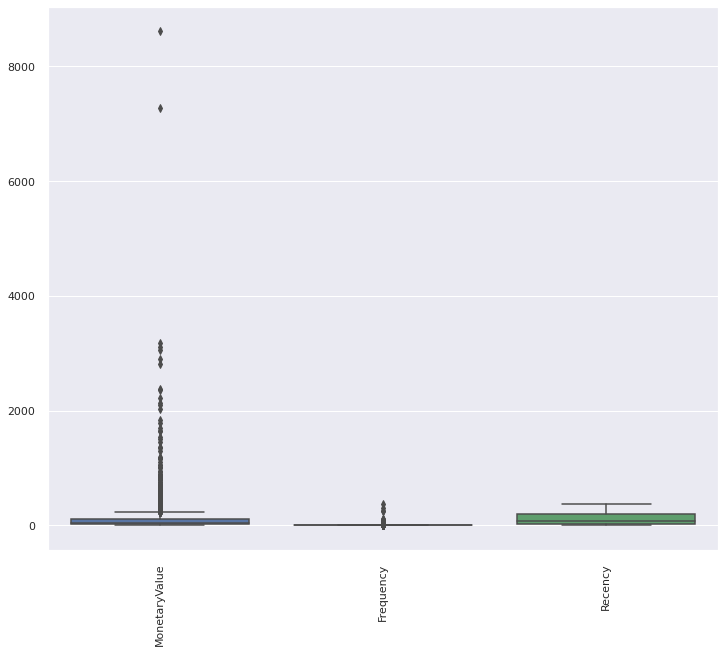

In [ ]:
X_test_anomaly = df_test1.iloc[:,0:3]
viewDistribution(X_test_anomaly)

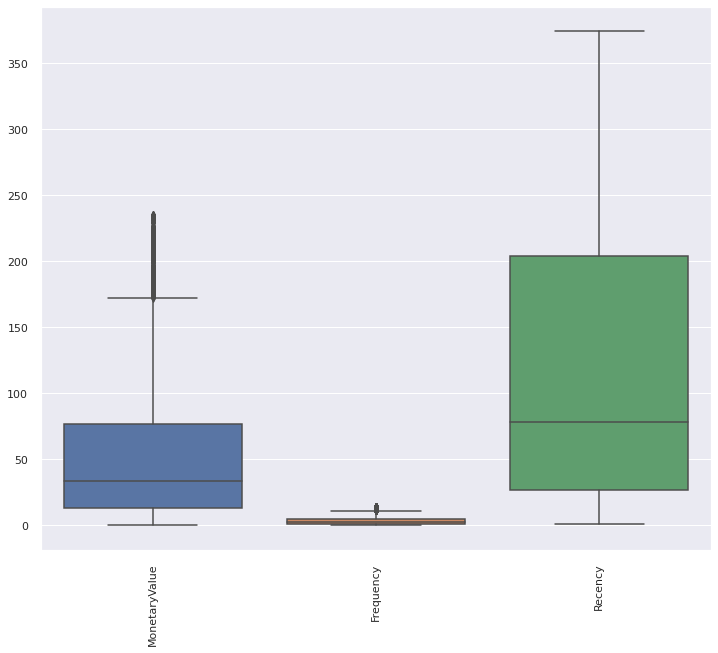

In [ ]:
X_test_IQR = remove_outlier_IQR(df_test1)
X_test_IQR.fillna(0,inplace=True)
viewDistribution(X_test_IQR.iloc[:,0:3])

In [ ]:
X_test_IQR.head()

,MonetaryValue,Frequency,Recency,Customer_status
0,160.90,0.0,337,0.0
1,28.07,5.0,278,0.0
2,100.83,10.0,94,0.0
3,159.55,12.0,19,0.0
4,143.86,13.0,37,0.0


In [ ]:
X_test_scaled = scaler.transform(X_test_IQR)
Xtest_df = pd.DataFrame(X_test_scaled, columns=["MonetaryValue", "Frequency", "Recency","Customer_status"])
X = Xtest_df.drop('Customer_status', axis=1)
X.head()

,MonetaryValue,Frequency,Recency
0,-0.625585,-0.834231,2.000915
1,-0.809581,-0.735520,1.466400
2,-0.708794,-0.636809,-0.200561
3,-0.627455,-0.597325,-0.880029
4,-0.649189,-0.577583,-0.716957


In [ ]:
pred_test = kmeans1.predict(X)
X['ClusterID'] = pred_test
X['ClusterID'].value_counts()

0    2750
2    1445
Name: ClusterID, dtype: int64

In [ ]:
X_test_IQR['ClusterID'] = pred_test

In [ ]:
summary = X_test_IQR.groupby(['ClusterID']).agg({'Recency': 'mean',
                                                    'Frequency': 'mean',
                                                    'MonetaryValue': ['mean', 'count'],}).round(0)

[Text(0, 0.5, 'Recency')]

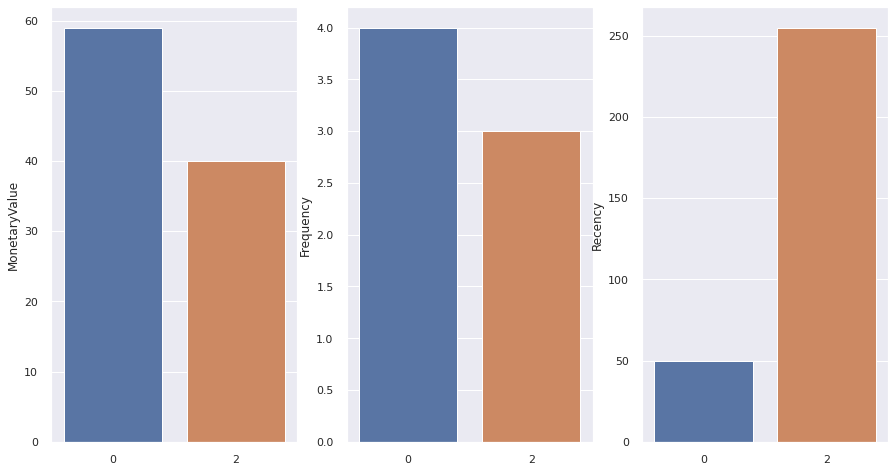

In [ ]:
fig, axs = plt.subplots(1,3, figsize = (15, 8))
axs[0] = sns.barplot(x = [0,2],  y = summary[:]['MonetaryValue']['mean'] , ax = axs[0],)
axs[1] = sns.barplot(x = [0,2],  y = summary[:]['Frequency']['mean'] , ax = axs[1])
axs[2] = sns.barplot(x = [0,2],  y = summary[:]['Recency']['mean'] , ax = axs[2])

axs[0].set( ylabel='MonetaryValue')
axs[1].set( ylabel='Frequency')
axs[2].set( ylabel='Recency')

In [ ]:
X2_test = Xtest_df.drop('Recency', axis=1)
pred2_test = kmeans2.predict(X2_test)
X2_test['ClusterID'] = pred2_test
X2_test['ClusterID'].value_counts()

2    3290
0     905
Name: ClusterID, dtype: int64